In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-review/Reviews.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

df = pd.read_csv('/kaggle/input/amazon-fine-food-review/Reviews.csv')

In [3]:
#using the vader model it only rated words individually. This model looks at the relationship between words.
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification as AMSC
from scipy.special import softmax
from tqdm.notebook import tqdm

In [4]:
df=df.head(500)

In [5]:
model = f'cardiffnlp/twitter-roberta-base-sentiment'
#this is a pretrained model and this is then downloaded and was trained on twitter tweets that were labled.
tokenizer = AutoTokenizer.from_pretrained(model)
model = AMSC.from_pretrained(model)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [6]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg':scores[0],
        'roberta_neu':scores[1],
        'roberta_pos':scores[2]
    }
    return scores_dict

In [7]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
    #store the id and score in a dictionary
        roberta_result = polarity_scores_roberta(text)
        res[myid]=roberta_result
    except RuntimeError:
        print(f'Broke for ID {myid}')
        #temp fix for breaks in the code where text is too long

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for ID 83
Broke for ID 187


In [8]:
roberta = pd.DataFrame(res).T
roberta = roberta.reset_index().rename(columns={'index': 'Id'})
roberta = roberta.merge(df, how='left')
roberta

,Id,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,496,0.001906,0.009862,0.988232,B000G6RYNE,APGAA43E3WPN7,Darren,0,0,5,1201392000,amazing chips,i rarely eat chips but i saw these and tried t...
494,497,0.004415,0.034215,0.961369,B000G6RYNE,ABR7HU5H1KNE,Keith,0,0,5,1196726400,Best Chip Ever,This is easily the best potato chip that I hav...
495,498,0.006427,0.074537,0.919036,B000G6RYNE,AJQD2WWJYOYFQ,bubbles,0,0,4,1186617600,"Tangy, spicy, and sweet- oh my!",Kettle Chips Spicy Thai potato chips have the ...
496,499,0.865614,0.119366,0.015020,B000G6RYNE,A16YH487W9ZYO0,Bruce G. Lindsay,0,0,4,1184198400,An indulgence with a bite,"Okay, I should not eat potato chips, nor shoul..."


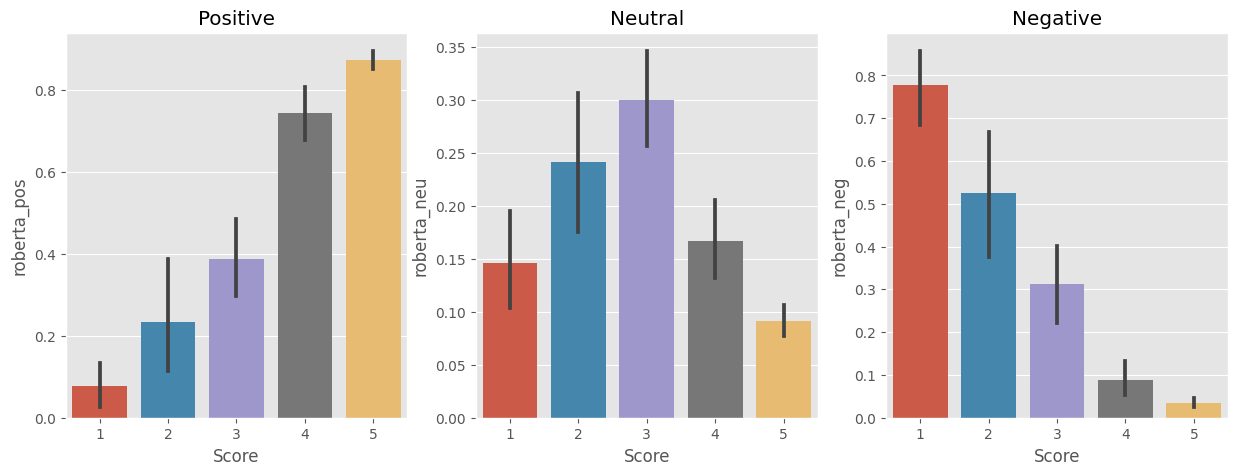

In [9]:
figs, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=roberta, x="Score", y="roberta_pos", ax=axs[0])
sns.barplot(data=roberta, x="Score", y="roberta_neu", ax=axs[1])
sns.barplot(data=roberta, x="Score", y="roberta_neg", ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.show()